In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import seaborn as sns
import matplotlib.pyplot as plt

/home/kchen/miniconda3/envs/tf/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/kchen/miniconda3/envs/tf/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from math import sqrt

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV

data = pd.read_csv('../data/crc_folfox_mut_cna_fus_clin.csv', index_col=0)
data.head()


2023-10-23 14:29:00.349131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 14:29:01.315537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,id_institution,id_drugs_list,OS,id_tt_os_g_mos,PFS,id_tt_pfs_m_g_mos,mut_CDK4,mut_CCND3,mut_CDH1,mut_CDK8,...,clin_ca_first_dmets1,clin_ca_crc_td,clin_ca_crc_crm,clin_ca_crc_peri_inv,clin_crc_type,OS_time,clin_Histology Category,clin_Histology,clin_Derived Grade or Differentiation of Tumor,clin_CEA
GENIE-DFCI-000233,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,100.986842,0.0,31.578947,0,0,0,0,...,5,2,2,0,2,3303,0,0,1,1.0
GENIE-DFCI-000247,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",1,35.789474,0.0,3.914474,0,0,0,0,...,0,2,0,0,2,1163,0,0,0,4.9
GENIE-DFCI-000306,DFCI,"bev, Fluorouracil, Leucovorin Calcium, Oxalipl...",0,38.125000,0.0,12.960526,0,0,0,0,...,1,2,2,0,3,1230,0,0,1,0.7
GENIE-DFCI-000738,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,51.578947,NaN,NaN,0,0,0,0,...,5,0,2,0,3,1623,0,1,1,1.8
GENIE-DFCI-000924,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,65.361842,NaN,NaN,0,0,0,0,...,5,0,2,1,0,2039,0,0,1,0.6


In [3]:

import datetime
today = datetime.date.today()
today_str = today.strftime('%m%d%y')
hp_date = '102123'

drug = 'folfox'
outcome = 'OS'
data_type = 'nonclin'
lasso_c = 2
data = pd.read_csv('../data/crc_{}_mut_cna_fus_clin.csv'.format(drug))
data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
data = data.dropna(subset=[outcome])
data.reset_index(inplace=True, drop=True)

hp_res = {}
for i in range(0, 5):
    hp_res[i] = pd.read_csv(f'../results/hp_search/results_rf_lasso_folfox_OS_nonclin_102123_{i}.csv', index_col=0)
    hp_res[i] = hp_res[i].set_index('rank_test_score')
hp_res[0].head()

hp_res[0]['param_n_estimators'][1]
def make_rf_model(fold):
    n_estimators = hp_res[fold]['param_n_estimators'][1]
    n_estimators = int(n_estimators)
    max_depth = hp_res[fold]['param_max_depth'][1]
    max_depth = int(max_depth)
    min_samples_split = hp_res[fold]['param_min_samples_split'][1]
    min_samples_split = int(min_samples_split)
    min_samples_leaf = hp_res[fold]['param_min_samples_leaf'][1]
    min_samples_leaf = int(min_samples_leaf)
    max_features = hp_res[fold]['param_max_features'][1]
    bootstrap = hp_res[fold]['param_bootstrap'][1]
    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        max_features=max_features,
                                        bootstrap=bootstrap,
                                        random_state=42)
    return rf_model
rf = make_rf_model(0)

data['rf_preds'] = np.NaN
data.head()
#create 5 train, test splits, within each train, create 5 train, valid splits
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
groups = data['id']
X = data[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col or 'fus' in col]]
y = data[outcome]

res_df = pd.DataFrame(columns=['fold', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auprc_mean'])
fold_count = 0
for train_index, test_index in skf.split(X, y, groups):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    if (data_type != 'comb') & (data_type != 'nonclin'):
        X_train = X_train[[col for col in data.columns if '{}_'.format(data_type) in col]]
        X_test = X_test[[col for col in data.columns if '{}_'.format(data_type) in col]]
    elif data_type == 'nonclin':
        X_train = X_train[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'fus' in col]]
        X_test = X_test[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'fus' in col]]
    else:
        X_train = X_train[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col or 'fus' in col]]
        X_test = X_test[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col or 'fus' in col]]

    #use lasso to select features
    lasso = LogisticRegression(penalty='l1', C=lasso_c, solver='liblinear')
    lasso.fit(X_train, y_train)
    lasso_coef = lasso.coef_
    lasso_coef = lasso_coef[0]
    lasso_coef = pd.DataFrame({'feature': X_train.columns, 'coef': lasso_coef})
    lasso_coef = lasso_coef[lasso_coef['coef'] != 0]
    X_train = X_train[lasso_coef['feature']]
    X_test = X_test[lasso_coef['feature']]
    
    #print the number of mut_, cna_, and fus_ features selected
    print('fold {}'.format(fold_count))
    print('mut: {}'.format(len([col for col in X_train.columns if 'mut_' in col])))
    print('cna: {}'.format(len([col for col in X_train.columns if 'cna_' in col])))
    print('fus: {}'.format(len([col for col in X_train.columns if 'fus_' in col])))
    

    rf = make_rf_model(fold_count)
    rf.fit(X_train, y_train)

    preds = rf.predict_proba(X_train)[:,1]
    data.loc[train_index, 'rf_preds'] = preds


fold 0
mut: 140
cna: 127
fus: 24


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


fold 0
mut: 131
cna: 125
fus: 25


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


fold 0
mut: 134
cna: 130
fus: 24


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


fold 0
mut: 146
cna: 124
fus: 25


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(X_test)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

#get the mean absolute value for each feature
shap_mean = pd.DataFrame(shap_df.mean(), columns=['importance'])
shap_mean.index.rename('feature', inplace=True)
shap_mean['abs_importance'] = np.abs(shap_mean['importance'])
shap_mean = shap_mean.sort_values('abs_importance', ascending=False)
fi = shap_mean.copy()

fi.reset_index(inplace=True)
fi.rename(columns={'feature':'Variable', 'importance':'Importance'}, inplace=True)
#makes the darkest blue at the top and lightest blue at the bottom
palette = sns.color_palette("Blues_d", n_colors=12)
palette.reverse()
#create a horizontal bar plot of the top 10 features
plt.figure(figsize=(16,10))
sns.barplot(x='Importance', y='Variable', data=fi.head(12), palette=palette)
#increase font size
plt.tight_layout()
plt.rcParams["font.size"] = 20
plt.show()

In [5]:
today_str = '061623'

In [7]:
data = pd.read_csv('../data/crc_folfox_mut_cna_fus_clin.csv'.format(drug), index_col=0)
data['clin_stage_dx'].value_counts()

clin_stage_dx
4    716
3    406
2    123
0     40
1      5
Name: count, dtype: int64

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(X_test)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

#get the mean absolute value for each feature
shap_mean = pd.DataFrame(shap_df.mean(), columns=['importance'])
shap_mean.index.rename('feature', inplace=True)
shap_mean['abs_importance'] = np.abs(shap_mean['importance'])
shap_mean = shap_mean.sort_values('abs_importance', ascending=False)
fi = shap_mean.copy()

fi.reset_index(inplace=True)
fi.rename(columns={'feature':'Variable', 'importance':'Importance'}, inplace=True)
#makes the darkest blue at the top and lightest blue at the bottom
palette = sns.color_palette("Blues_d", n_colors=12)
palette.reverse()
#create a horizontal bar plot of the top 10 features
plt.figure(figsize=(16,10))
sns.barplot(x='Importance', y='Variable', data=fi.head(12), palette=palette)
#increase font size
plt.tight_layout()
plt.rcParams["font.size"] = 20

Running folfox OS
(1032, 469) (258, 469)
            AUROC     AUPRC   Recall  Precision
XGBoost  0.739032  0.641111  0.48913   0.616438


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running folfox PFS
(776, 469) (195, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.498972  0.295182  0.035714   0.222222


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running folfiri OS
(727, 469) (182, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.745019  0.690323  0.702381   0.662921


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running folfiri PFS
(705, 469) (177, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.503973  0.464405  0.253012   0.428571


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running egfr OS
(283, 469) (71, 469)
            AUROC    AUPRC  Recall  Precision
XGBoost  0.514022  0.49555  0.6875    0.44898


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running egfr PFS
(278, 469) (70, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.528183  0.340842  0.142857   0.428571


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running ib OS
(116, 469) (30, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.540724  0.582626  0.235294   0.571429


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running ib PFS
(110, 469) (28, 469)
            AUROC    AUPRC  Recall  Precision
XGBoost  0.416667  0.39442     1.0   0.428571


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running tri OS
(118, 469) (30, 469)
         AUROC     AUPRC  Recall  Precision
XGBoost   0.55  0.760727     0.9       0.72


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running tri PFS
(116, 469) (30, 469)
            AUROC     AUPRC  Recall  Precision
XGBoost  0.632275  0.804154     1.0        0.7


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


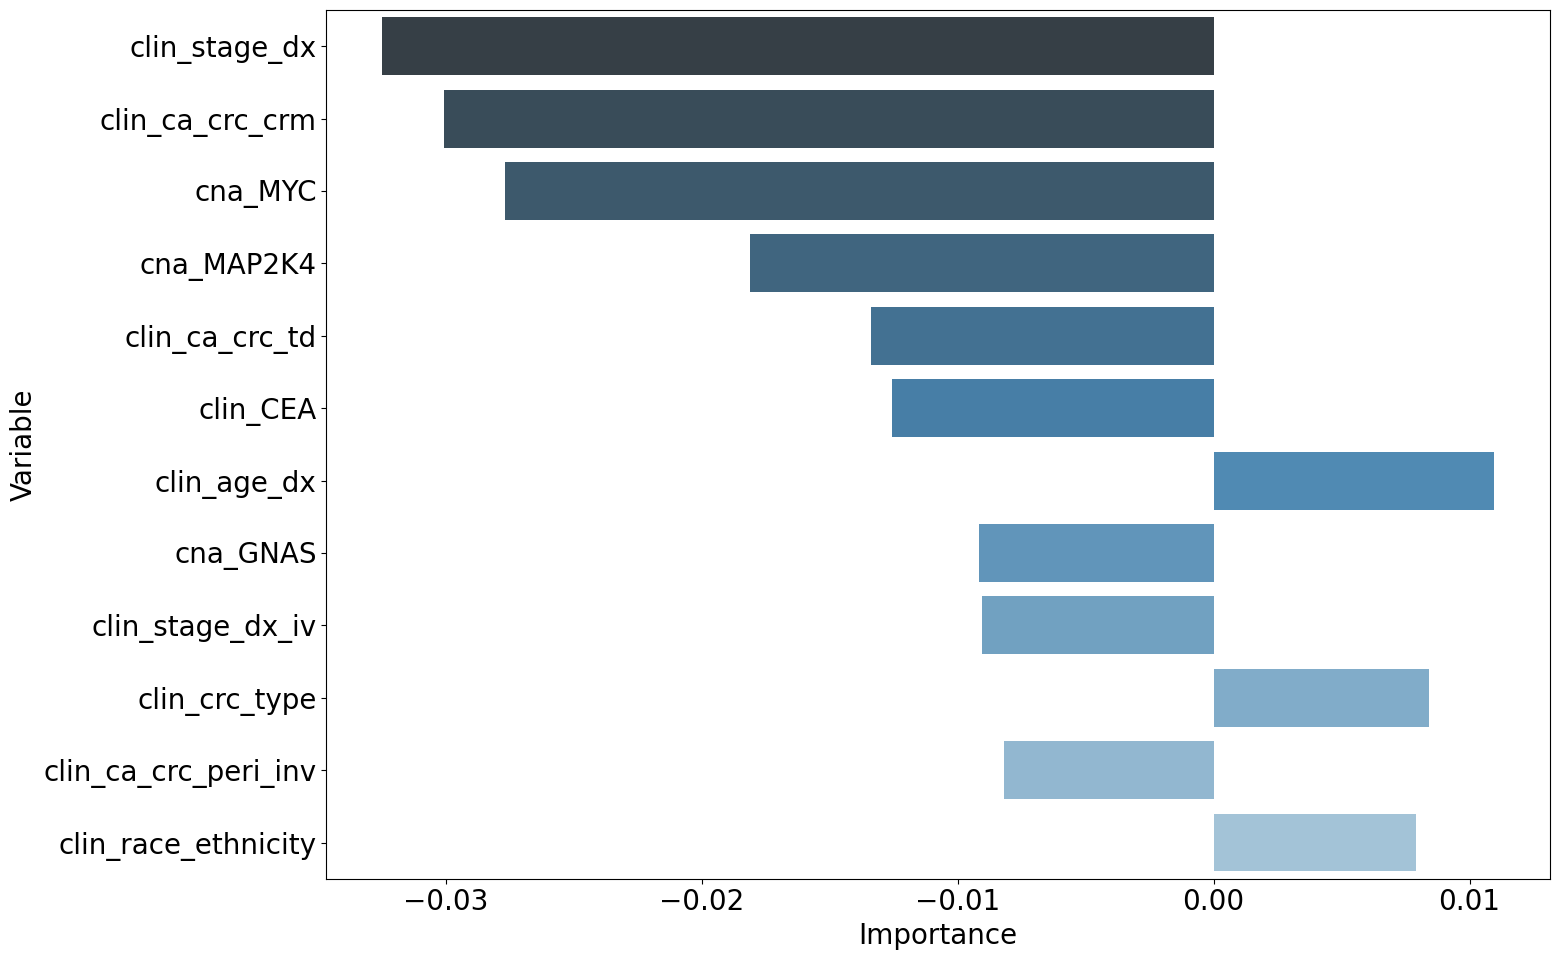

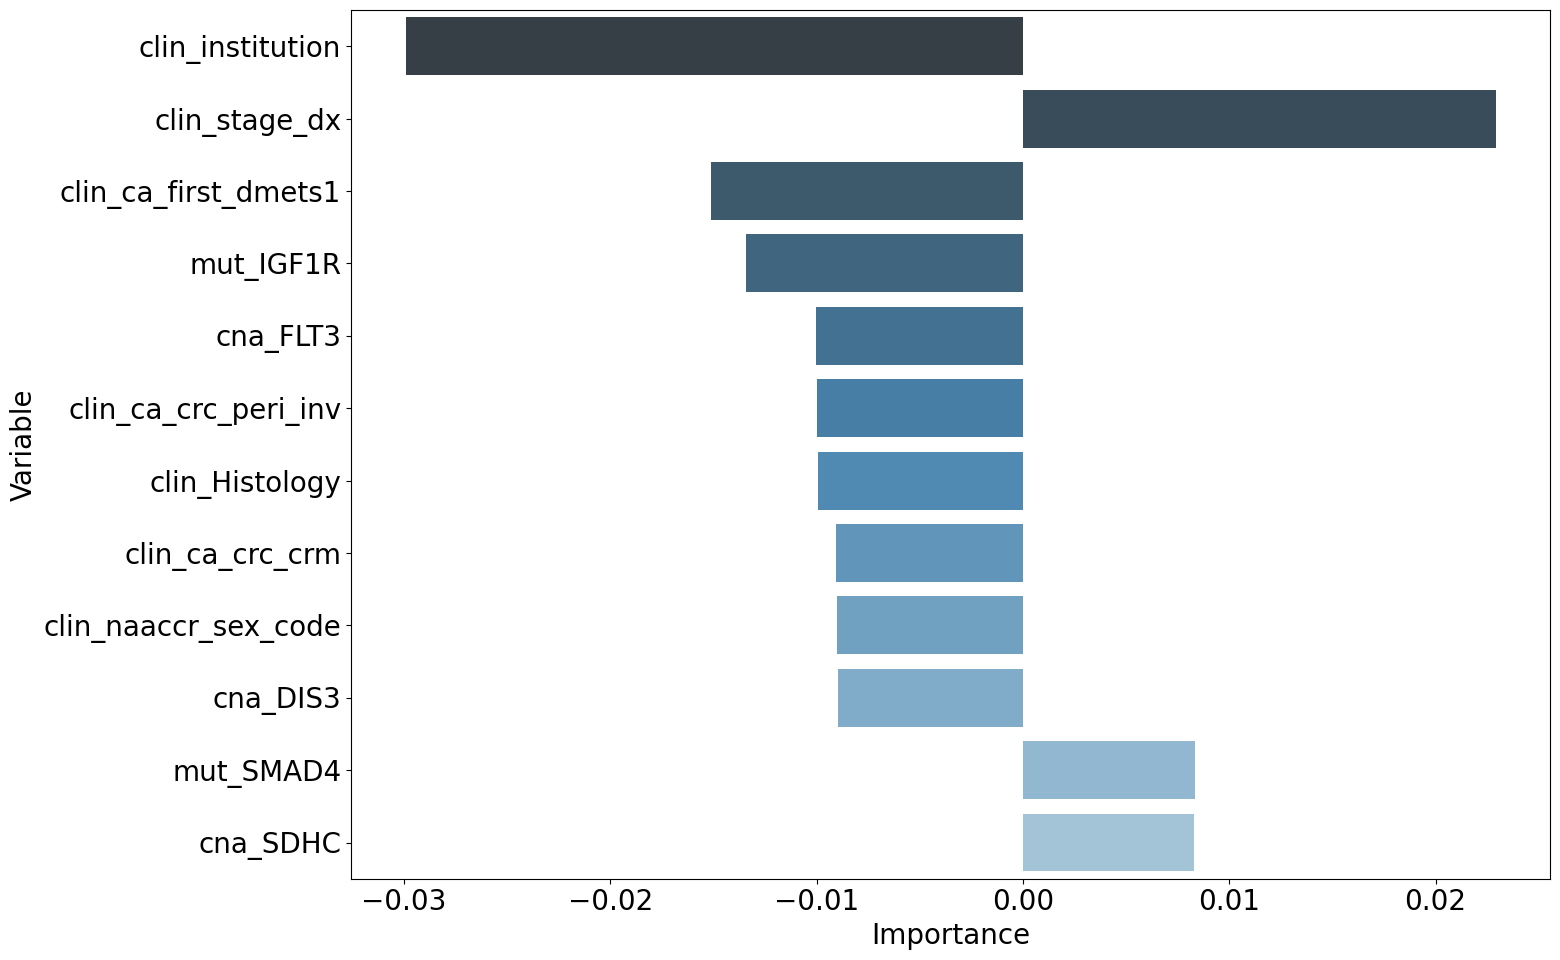

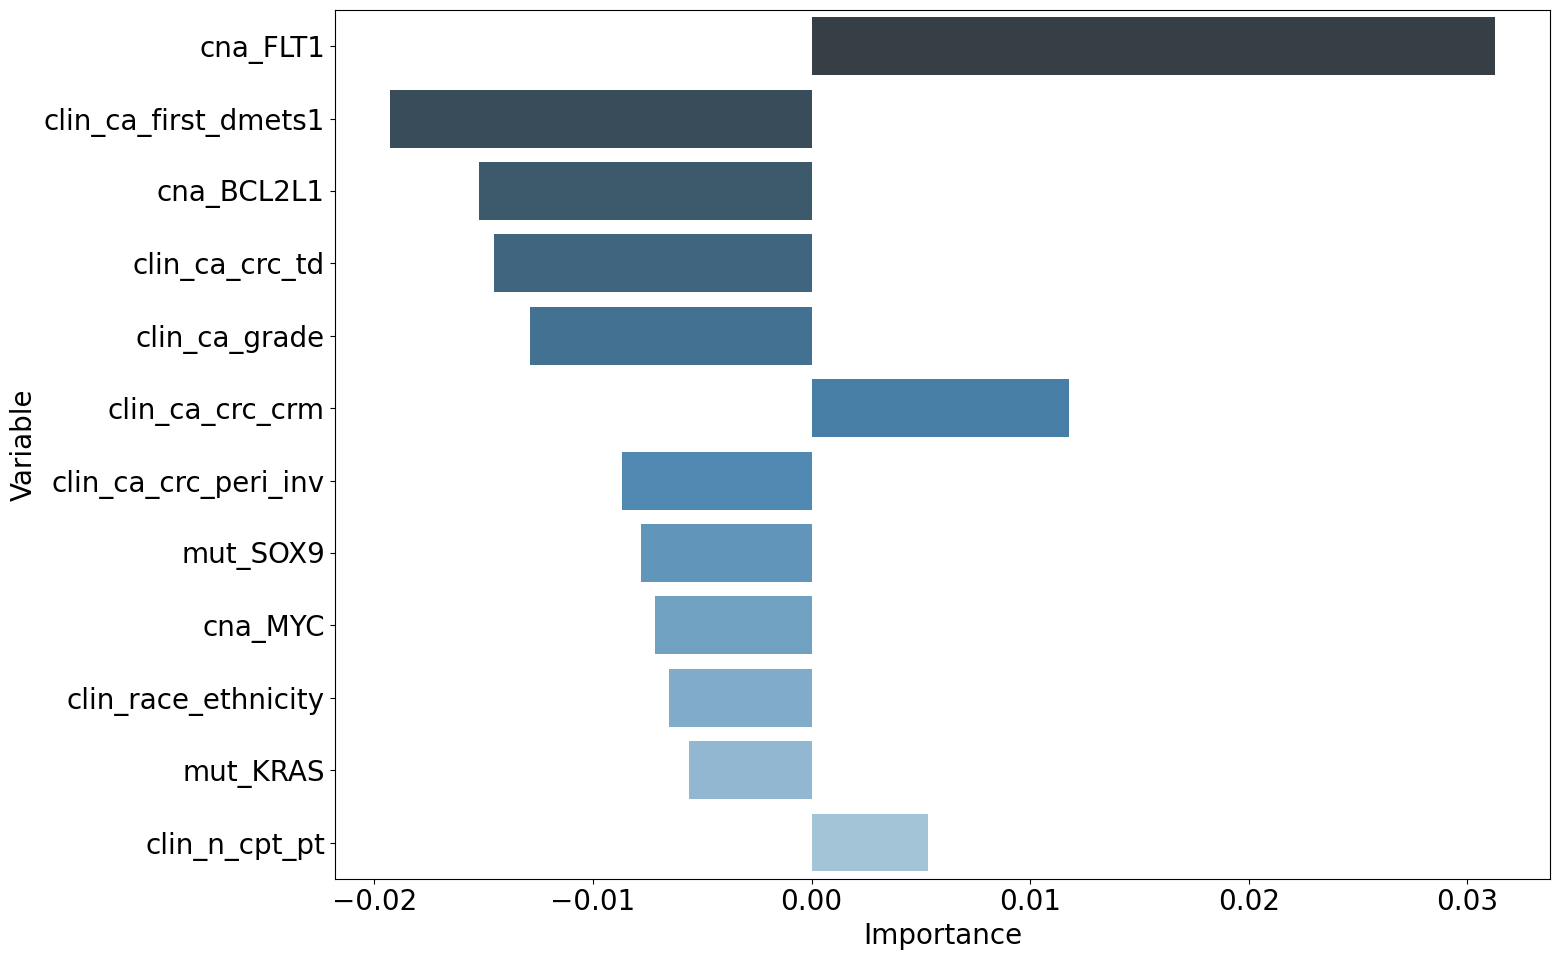

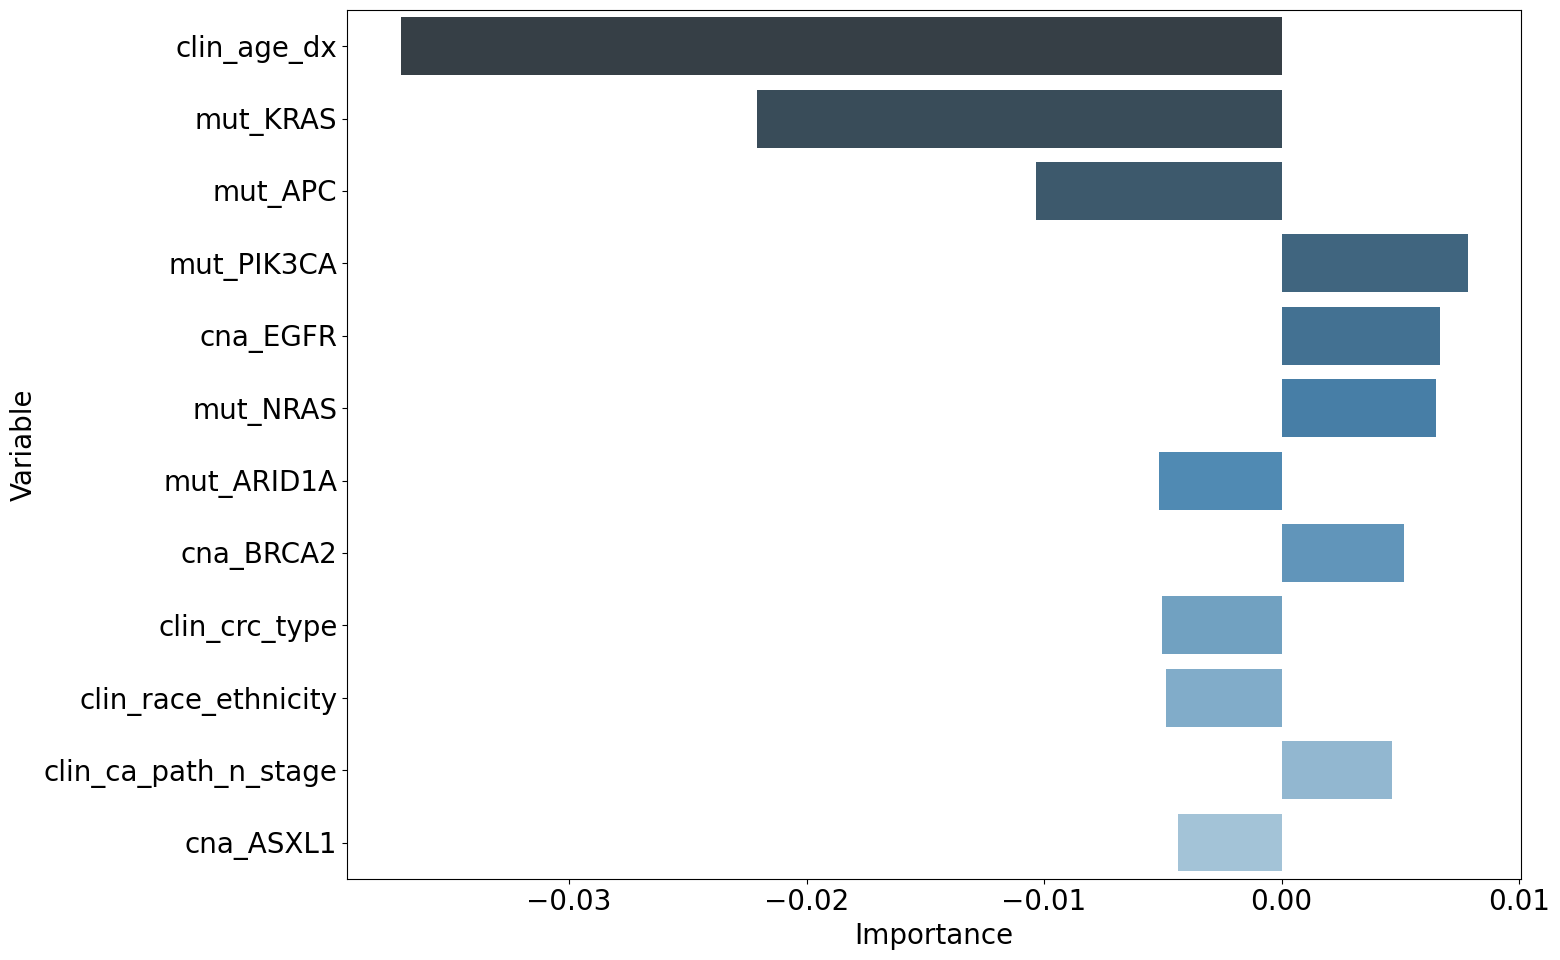

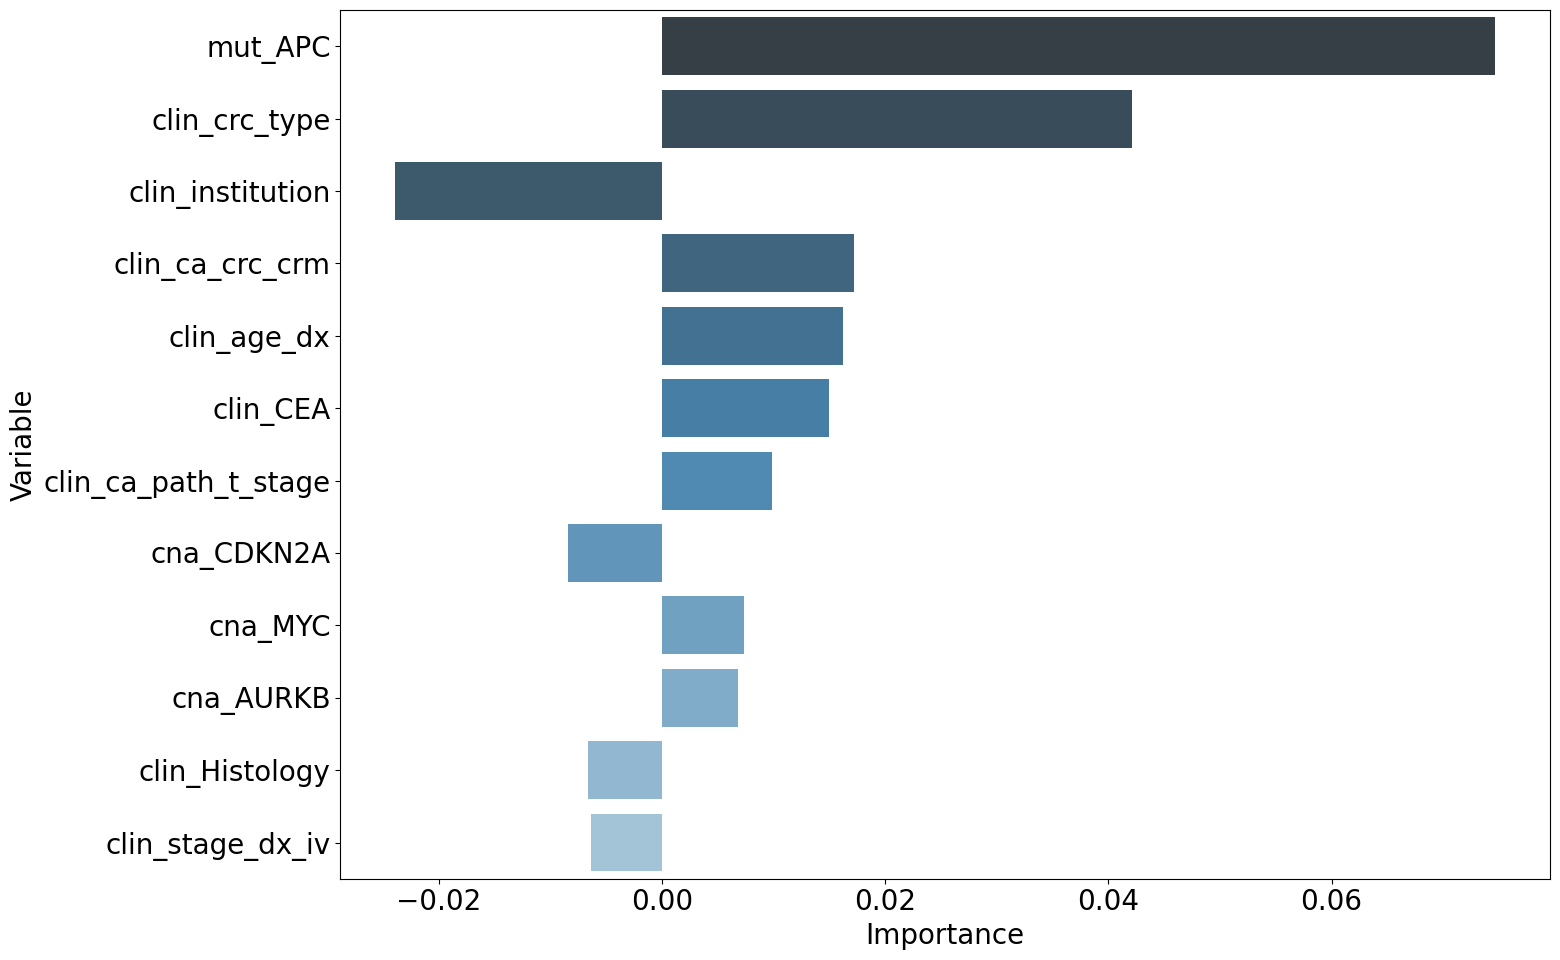

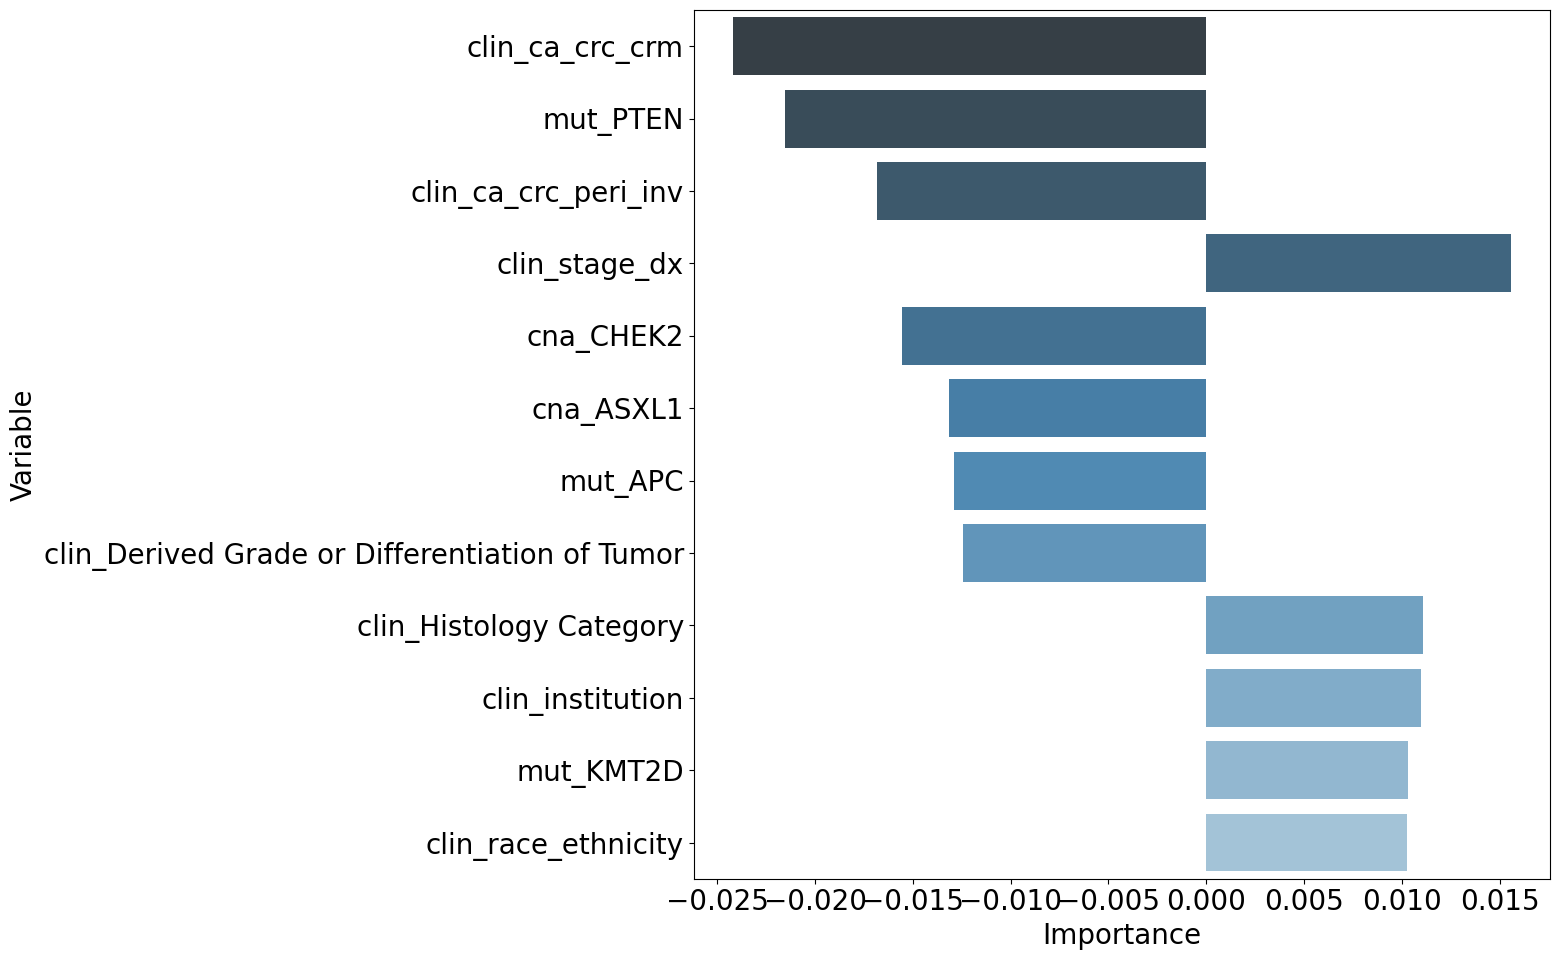

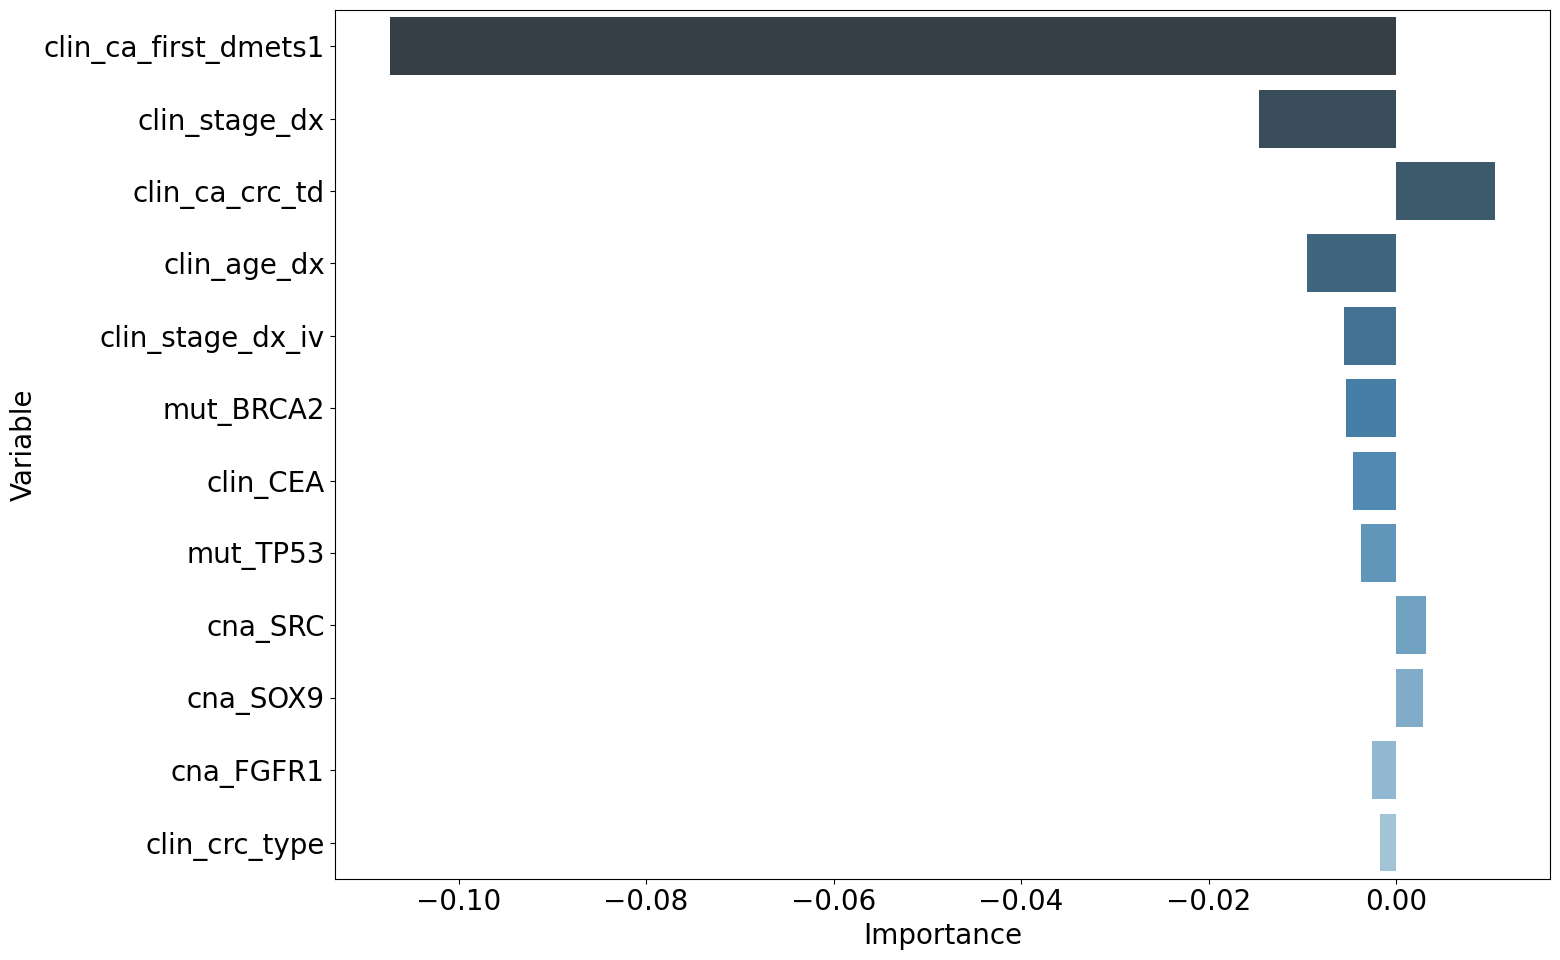

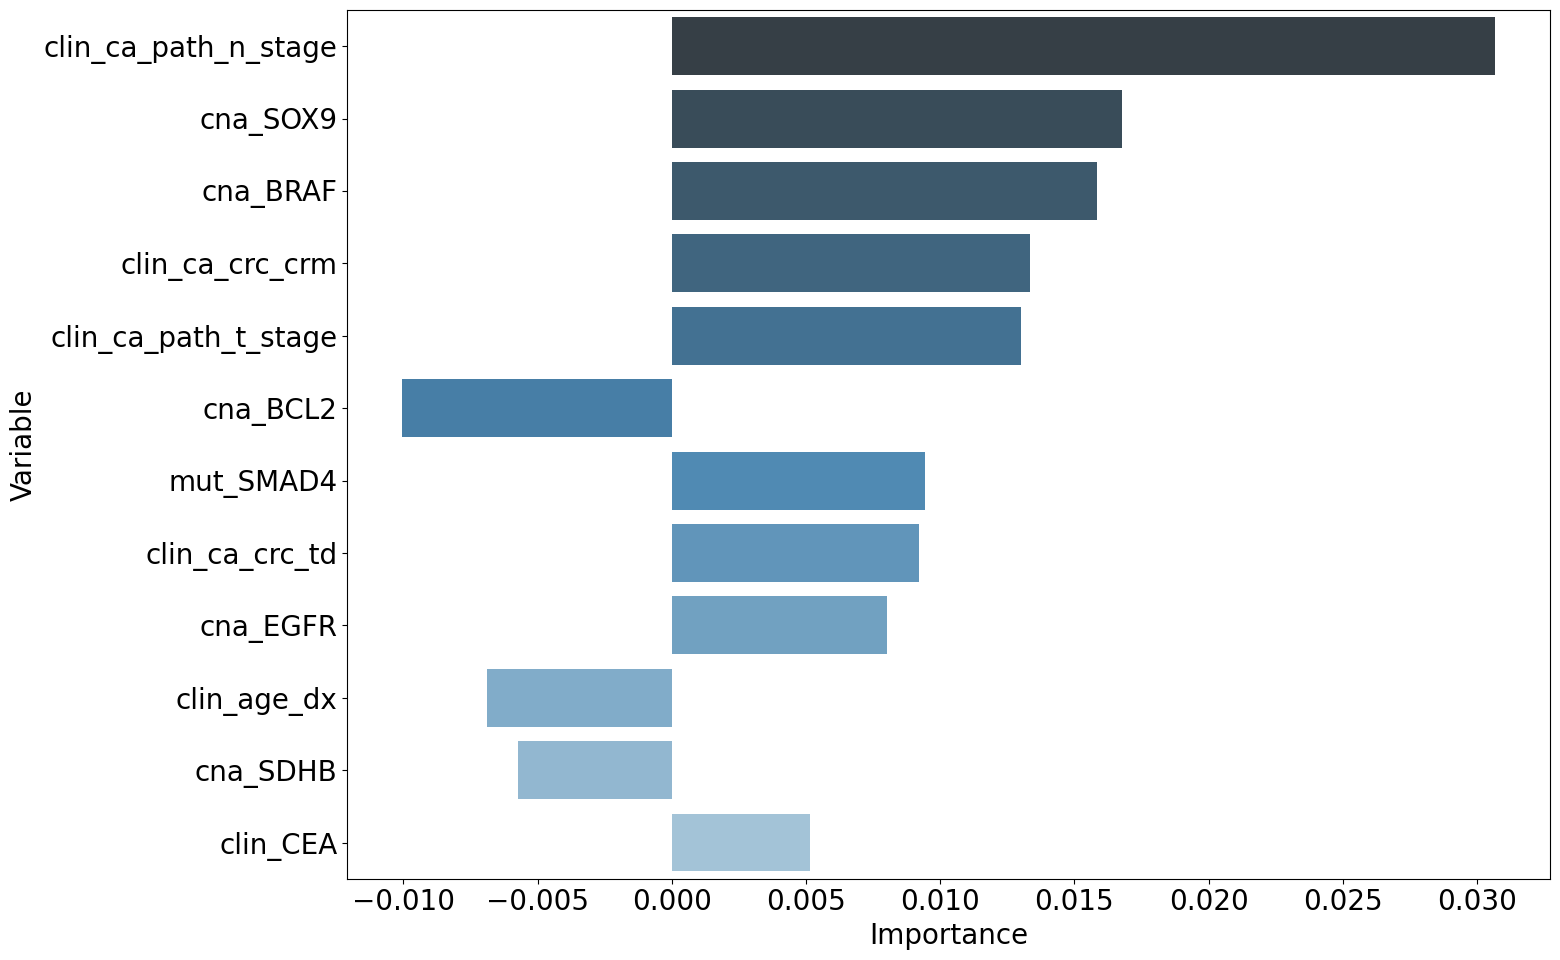

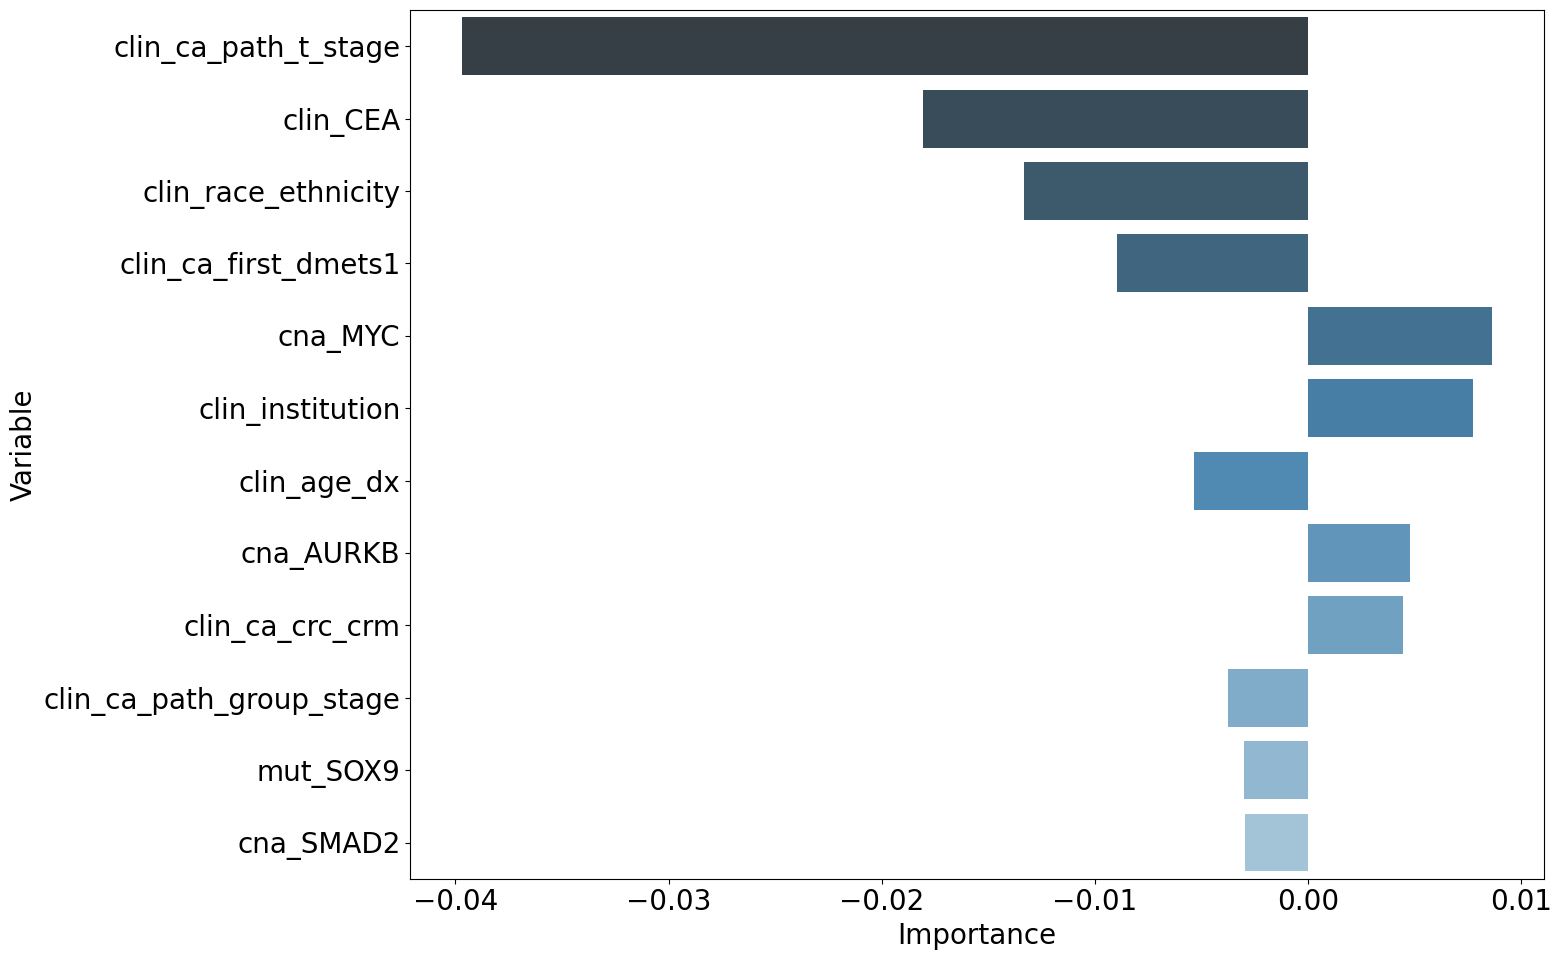

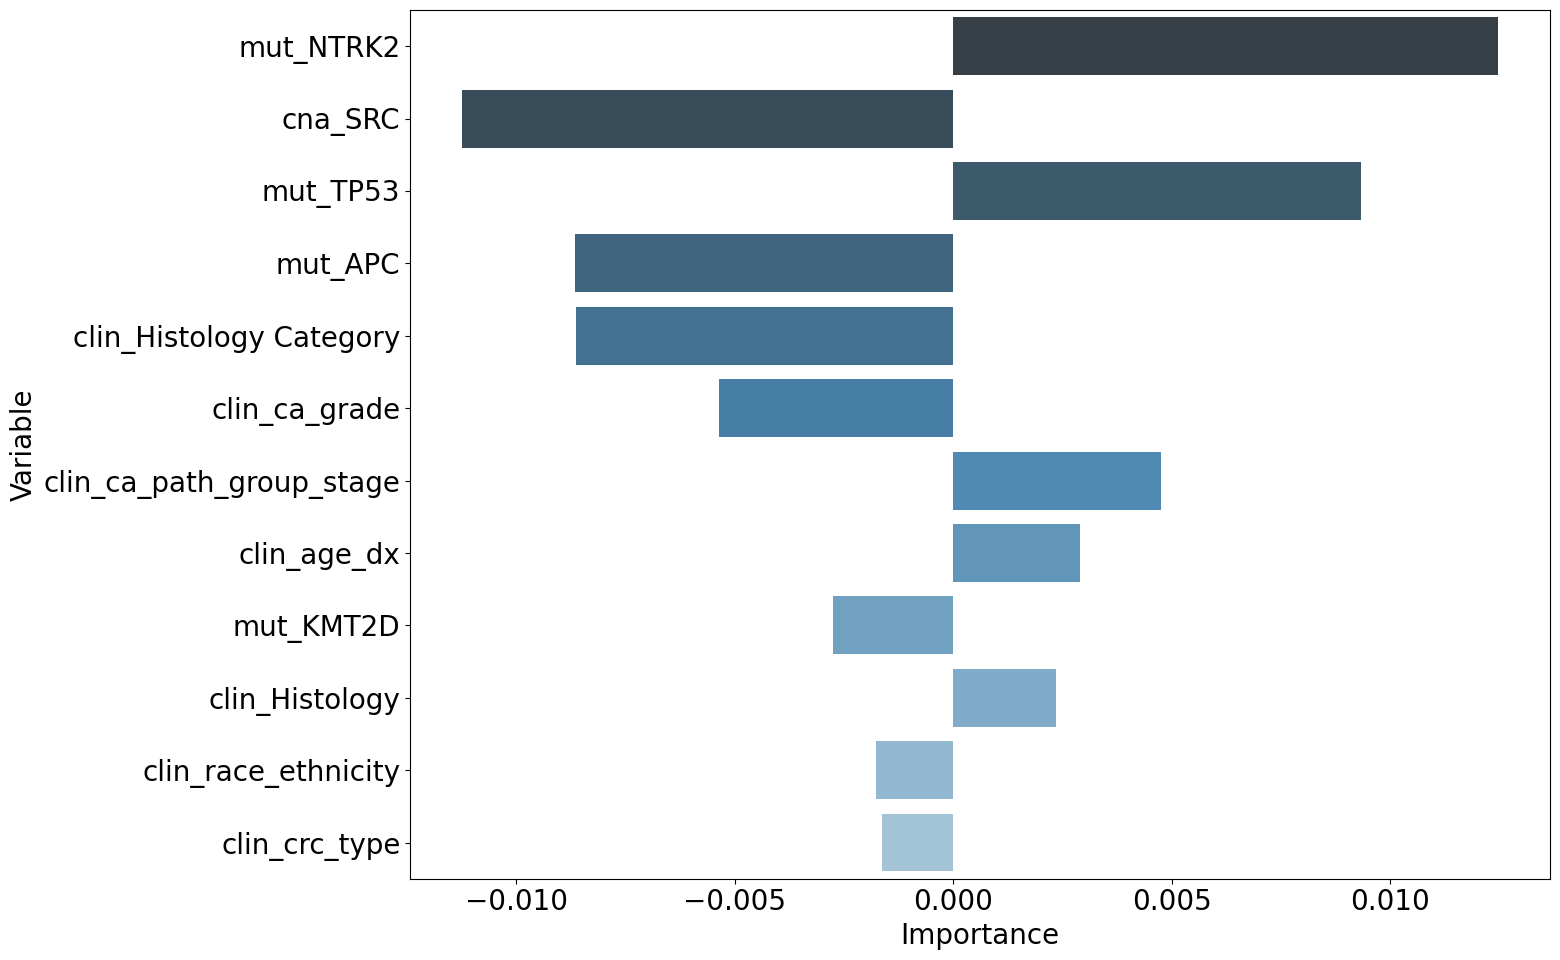

In [6]:
for drug in ['folfox', 'folfiri', 'egfr', 'ib', 'tri']:
    for outcome in ['OS', 'PFS']:
        print('Running', drug, outcome)
        data = pd.read_csv('../data/crc_{}_mut_cna_fus_clin.csv'.format(drug), index_col=0)
        data = data.dropna(subset=[outcome])
        X = data[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col]]
        y = data[outcome]
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
        print(X_train.shape, X_test.shape)
        xgb = XGBClassifier(n_estimators=50, max_depth=6, reg_alpha=5, reg_lambda=5, subsample=0.4, colsample_bytree=0.6, n_jobs=4)
        xgb.fit(X_train, y_train)
        res_df = pd.DataFrame(columns=['AUROC', 'AUPRC', 'Recall', 'Precision'])
        auroc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
        auprc = average_precision_score(y_test, xgb.predict_proba(X_test)[:, 1])
        recall = recall_score(y_test, xgb.predict(X_test))
        precision = precision_score(y_test, xgb.predict(X_test))
        res_df.loc['XGBoost'] = [auroc, auprc, recall, precision]
        print(res_df.head())

        explainer = shap.TreeExplainer(xgb)
        shap_values = explainer.shap_values(X_test)
        shap_obj = explainer(X_test)
        shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

        #get the mean absolute value for each feature
        shap_mean = pd.DataFrame(shap_df.mean(), columns=['importance'])
        shap_mean.index.rename('feature', inplace=True)
        shap_mean['abs_importance'] = np.abs(shap_mean['importance'])
        shap_mean = shap_mean.sort_values('abs_importance', ascending=False)
        fi = shap_mean.copy()

        fi.reset_index(inplace=True)
        fi.rename(columns={'feature':'Variable', 'importance':'Importance'}, inplace=True)
        #makes the darkest blue at the top and lightest blue at the bottom
        palette = sns.color_palette("Blues_d", n_colors=12)
        palette.reverse()
        #create a horizontal bar plot of the top 10 features
        plt.figure(figsize=(16,10))
        sns.barplot(x='Importance', y='Variable', data=fi.head(12), palette=palette)
        #increase font size
        plt.tight_layout()
        plt.rcParams["font.size"] = 20
        plt.savefig('../results/figures/shap/{}/shap_{}_{}.png'.format(today_str, drug, outcome), dpi=600, bbox_inches='tight')

In [ ]:
drug = 'folfox'
outcome = 'OS'

data = pd.read_csv('../data/crc_{}_mut_cna_clin.csv'.format(drug), index_col=0)
data = data.dropna(subset=[outcome])

In [ ]:
X = data[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col]]
y = data[outcome]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
print(X_train.shape, X_test.shape)

(1106, 469) (277, 469)


In [ ]:
xgb = RandomForestClassifier(n_estimators=1000)
xgb.fit(X_train, y_train)
res_df = pd.DataFrame(columns=['AUROC', 'AUPRC', 'Recall', 'Precision'])
auroc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
auprc = average_precision_score(y_test, xgb.predict_proba(X_test)[:, 1])
recall = recall_score(y_test, xgb.predict(X_test))
precision = precision_score(y_test, xgb.predict(X_test))
res_df.loc['XGBoost'] = [auroc, auprc, recall, precision]
res_df.head()

,AUROC,AUPRC,Recall,Precision
XGBoost,0.854702,0.865024,0.772414,0.767123


In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap_obj = explainer(X_test)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

#get the mean value for each feature
shap_mean = pd.DataFrame(shap_df.mean(), columns=['importance'])
shap_mean.index.rename('feature', inplace=True)
shap_mean['abs_importance'] = shap_mean['importance'].abs()
shap_mean = shap_mean.sort_values('abs_importance', ascending=False)
fi = shap_mean.copy()
fi.head()


ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 0.459963, while the model output was 0.462000. If this difference is acceptable you can set check_additivity=False to disable this check.

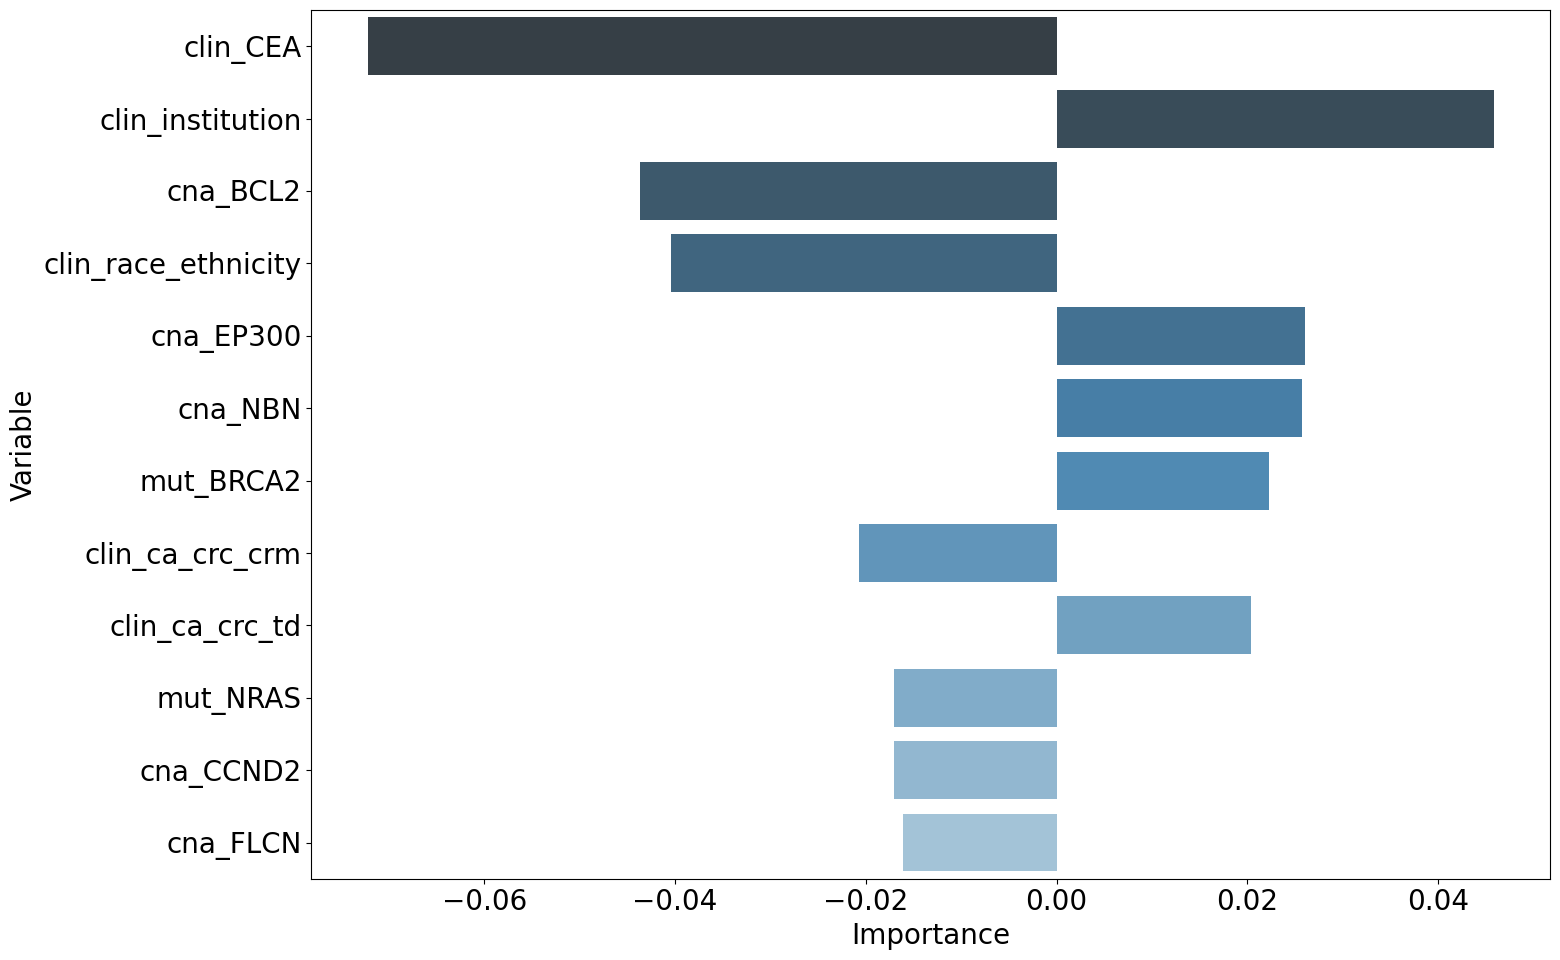

In [ ]:

fi.reset_index(inplace=True)
fi.rename(columns={'feature':'Variable', 'importance':'Importance'}, inplace=True)
#makes the darkest blue at the top and lightest blue at the bottom
palette = sns.color_palette("Blues_d", n_colors=12)
palette.reverse()
#create a horizontal bar plot of the top 10 features
plt.figure(figsize=(16,10))
sns.barplot(x='Importance', y='Variable', data=fi.head(12), palette=palette)
#increase font size
plt.tight_layout()
plt.rcParams["font.size"] = 20
plt.show()